# Projekt z Inżynierii Uczenia Maszynowego
Semestr letni 2020, WEiTI PW
## Autorzy
Przemysław Stawczyk

Maciej Szulik


## Porównanie modeli regresorów:
- Knn
- tree regressor
- xgboost regressor

In [16]:
import json
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import seaborn as sn


In [17]:
def clean_nan_rows(dataframe, print_stats=False):
    clean_df = dataframe.dropna(axis=0, how='any')
    if print_stats:
        print('Original Length=', len(dataframe), '\tCleaned Length=', len(clean_df), '\tMissing Data=',
              len(dataframe) - len(clean_df))
    return clean_df

def load_file(filename):
    with open(filename, encoding="utf8") as f:
        data = f.readlines()
        data = [json.loads(line) for line in data]  # convert string to dict format
        df = pd.json_normalize(data)
    return df

def load_tables():
    users = load_file(r'../data/users.jsonl')
    deliveries = load_file(r'../data//deliveries.jsonl')
    sessions = load_file(r'../data//sessions.jsonl')
    products = load_file(r'../data//products.jsonl')

    return users, deliveries, sessions, products

def create_subcategories(products):
    category_path_arr = products['category_path'].str.split(';', 2)
    category_arr = []
    subcategory_arr = []
    for path in category_path_arr:
        if type(path) == float:
            category_arr.append(path)
            subcategory_arr.append(path)
        else:
            category_arr.append(path[0])
            subcategory_arr.append(path[1])

    products['category'] = category_arr
    products['subcategory'] = subcategory_arr

    return products

def fill_missing_user_id(sessions):
    session_user_map = sessions[sessions["user_id"].notna()].set_index('session_id')['user_id'].to_dict()

    for i, row in sessions.iterrows():
        if np.isnan(row["user_id"]) and row["session_id"] in session_user_map:
            sessions.at[i, 'user_id'] = session_user_map[row["session_id"]]

    buy_sessions = sessions[sessions.event_type == 'BUY_PRODUCT']

    clean_nan_rows(dataframe=buy_sessions['user_id'], print_stats=False)

    return buy_sessions

def obtain_dataset_table():
    users, deliveries, sessions, products = load_tables()

    # create subcategories and fill missing user id
    products = create_subcategories(products)
    sessions = fill_missing_user_id(sessions)

    # drop deliveries with missing delivery time
    deliveries = deliveries.dropna()

    # inner join sessions and deliveries
    merged_data = pd.merge(left=sessions, right=deliveries, left_on='purchase_id', right_on='purchase_id')

    # left join users
    merged_data = pd.merge(left=merged_data, right=users, how='left', left_on='user_id', right_on='user_id')

    # left join products
    merged_data = pd.merge(left=merged_data, right=products, how='left', left_on='product_id', right_on='product_id')

    # delivery time in hours
    merged_data['delivery_timestamp'] = \
        pd.to_datetime(merged_data.delivery_timestamp)
    merged_data['purchase_timestamp'] = \
        pd.to_datetime(merged_data.purchase_timestamp)
    merged_data['delivery_total_time'] = \
        merged_data['delivery_timestamp'] - merged_data['purchase_timestamp']

    merged_data['delivery_total_time_hours'] = \
        merged_data['delivery_total_time'].dt.total_seconds() / 3600

    # drop unnecessary columns
    columns = ['session_id', 'purchase_id', 'user_id', 'product_id', 'event_type',
               'offered_discount', 'name', 'timestamp', 'product_name', 'street',
               'purchase_timestamp', 'delivery_timestamp', 'category_path']
    for col in columns:
        merged_data = merged_data.drop(col, axis=1)

    merged_data = clean_nan_rows(merged_data, print_stats=False)

    return merged_data

def code_labels(dataset):
    # code labels
    le_cat = preprocessing.LabelEncoder()
    categories = np.unique(np.array(dataset['category']))
    np.append(categories, 'missing')
    le_cat.fit(categories)
    dataset['category'] = le_cat.transform(dataset['category'])

    le_subcat = preprocessing.LabelEncoder()
    subcategories = np.unique(np.array(dataset['subcategory']))
    np.append(subcategories, 'missing')
    le_subcat.fit(subcategories)
    dataset['subcategory'] = le_subcat.transform(dataset['subcategory'])

    le_city = preprocessing.LabelEncoder()
    cities = np.unique(np.array(dataset['city']))
    np.append(cities, 'missing')
    le_city.fit(cities)
    dataset['city'] = le_city.transform(dataset['city'])

    return dataset, le_cat, le_subcat, le_city

In [18]:
dataset = obtain_dataset_table()
dataset, le_cat, le_subcat, le_city = code_labels(dataset)

dataset

,delivery_company,city,price,category,subcategory,delivery_total_time,delivery_total_time_hours
0,360.0,4,109.00,0,4,4 days 14:00:00,110.0
1,360.0,4,32.99,0,3,4 days 14:00:00,110.0
2,620.0,4,58.97,3,9,3 days 20:00:00,92.0
3,516.0,4,69.00,0,4,2 days 17:00:00,65.0
4,360.0,4,-49.99,0,4,4 days 14:00:00,110.0
...,...,...,...,...,...,...,...
6572,620.0,7,129.00,3,0,4 days 10:00:00,106.0
6573,360.0,7,299.00,3,0,4 days 19:00:00,115.0
6574,620.0,7,58.97,3,9,4 days 10:00:00,106.0
6575,620.0,7,78.90,2,6,4 days 10:00:00,106.0


In [19]:
target = dataset['delivery_total_time_hours']
data = dataset.drop(['delivery_total_time', 'delivery_total_time_hours'], axis=1)

data

,delivery_company,city,price,category,subcategory
0,360.0,4,109.00,0,4
1,360.0,4,32.99,0,3
2,620.0,4,58.97,3,9
3,516.0,4,69.00,0,4
4,360.0,4,-49.99,0,4
...,...,...,...,...,...
6572,620.0,7,129.00,3,0
6573,360.0,7,299.00,3,0
6574,620.0,7,58.97,3,9
6575,620.0,7,78.90,2,6


## Split dataset on training and testing set

In [20]:
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=0)

## Train models

For comparison we will use exhaustive search. For normal work randomized >50% of options will be checked.

In [21]:
def train_model(target, data, model_type='xgb', random_seed=42, randomized=True):
    params = {}
    model = None
    crv = None
    n_iter = 0

    if model_type == 'xgb':
        model = xgb.XGBRegressor()
        params = {
            'objective': ['reg:squarederror'],
            'eval_metric': ['rmse'],
            'learning_rate': [0.03, 0.05, 0.07],  # so called `eta` value
            'max_depth': [4, 5, 6, 7],
            'min_child_weight': [4],
            'silent': [1],
            'n_estimators': [200, 320, 450, 600],
            'seed': [random_seed]
        }
        n_iter = 28
    elif model_type == 'tree':
        model = DecisionTreeRegressor()
        params = {
            'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
            'random_state': [random_seed],
            'criterion': ['mse', 'friedman_mse', 'mae'],
            'splitter': ['best', 'random']
        }
        n_iter = 30  # ~half of possible combinations
    elif model_type == 'knn':
        model = KNeighborsRegressor()
        params = {
            'n_neighbors': [3, 4, 5, 6, 8, 12, 15, 18, 22],
            'weights': ['uniform', 'distance'],
            'algorithm': ['ball_tree', 'kd_tree'],
        }
        n_iter = 20  # ~half of possible combinations
    else:
        return NotImplemented

    if randomized:
        crv = RandomizedSearchCV(model, params, random_state=random_seed, n_iter=n_iter,
                                 cv=KFold(n_splits=4, random_state=random_seed, shuffle=True), refit=True,
                                 scoring='neg_mean_squared_error')
    else:
        crv = GridSearchCV(model, params, cv=KFold(n_splits=4, random_state=random_seed, shuffle=True), refit=True,
                           scoring='neg_mean_squared_error')

    crv.fit(data, target)

    return crv.best_estimator_, crv.best_params_

In [22]:
model_knn, params_knn = train_model(y_train, x_train, model_type='knn', randomized=False)
params_knn

{'algorithm': 'kd_tree', 'n_neighbors': 8, 'weights': 'distance'}

In [23]:
model_tree, params_tree = train_model(y_train, x_train, model_type='tree',randomized=False)
params_tree

{'criterion': 'mse', 'max_depth': 7, 'random_state': 42, 'splitter': 'best'}

In [24]:
model_xgb, params_xgb = train_model(y_train, x_train, model_type='xgb',randomized=False)
params_xgb


{'eval_metric': 'rmse',
 'learning_rate': 0.07,
 'max_depth': 7,
 'min_child_weight': 4,
 'n_estimators': 320,
 'objective': 'reg:squarederror',
 'seed': 42,
 'silent': 1}

## Compare models on test data

In [25]:
def calc_metrics(predictions, test_y):
    err = max_error(test_y, predictions)
    avg = mean_absolute_error(test_y, predictions)
    avg_sqr = mean_squared_error(test_y, predictions)

    return [err, avg, avg_sqr]

def compare_models(models, test_X, test_y):
    test_predictions = []
    for mdl in models:
        test_predictions.append(mdl.predict(test_X))

    err = []
    for mdl_pred in test_predictions:
        err.append(calc_metrics(mdl_pred, test_y))

    error = pd.DataFrame.from_records(err, columns=['max error', 'avg error', 'avg sqr error'],
                                      index=['mdl-' + str(index + 1) for index in range(len(models))])
    ret = pd.DataFrame.from_records(test_X)
    ret['target'] = test_y
    for index, mdl in enumerate(models):
        ret['mdl-' + str(index + 1)] = test_predictions[index]

    return ret, error

In [26]:
predictions, error = compare_models([model_knn, model_tree, model_xgb], x_test, y_test)

error = error.rename(index={'mdl-1': 'kNN', 'mdl-2': 'tree', 'mdl-3': 'xgb'})
predictions = predictions.rename(columns={'mdl-1': 'kNN', 'mdl-2': 'tree', 'mdl-3': 'xgb'})

predictions['category'] = le_cat.inverse_transform(predictions['category'])
predictions['subcategory'] = le_subcat.inverse_transform(predictions['subcategory'])
predictions['city'] = le_city.inverse_transform(predictions['city'])

error

,max error,avg error,avg sqr error
kNN,48.243194,1.397963,3.076448e+01
tree,0.000000,0.000000,0.000000e+00
xgb,0.000137,0.000047,3.813179e-09


In [27]:
predictions.head(25)

,delivery_company,city,price,category,subcategory,target,kNN,tree,xgb
0,620.0,Kutno,-4.999000e+01,Gry i konsole,Gry na konsole,NaN,72.363636,74.0,73.999908
1,516.0,Police,2.317020e+03,Komputery,Tablety i akcesoria,110.0,65.000000,65.0,64.999939
2,516.0,Gdynia,-6.118000e+01,Gry i konsole,Gry na konsole,NaN,43.000000,43.0,43.000008
3,516.0,Szczecin,2.317020e+03,Komputery,Tablety i akcesoria,NaN,85.000000,85.0,85.000015
4,620.0,Gdynia,1.687900e+02,Sprzęt RTV,Video,110.0,57.973934,74.0,73.999962
5,516.0,Konin,-6.118000e+01,Gry i konsole,Gry na konsole,NaN,37.000000,37.0,37.000046
6,620.0,Warszawa,5.259000e+03,Komputery,Drukarki i skanery,NaN,106.000000,106.0,105.999985
7,620.0,Mielec,8.628000e+01,Telefony i akcesoria,Akcesoria telefoniczne,NaN,68.000000,68.0,68.000000
8,620.0,Kutno,7.890000e+01,Sprzęt RTV,Przenośne audio i video,65.0,74.000000,74.0,73.999908
9,360.0,Szczecin,1.816970e+03,Komputery,Tablety i akcesoria,NaN,135.000000,135.0,134.999863


As we can see xgboost and tree model performs a lot better than KNN regressor. Lets compare diffrences between those two models.


In [28]:
predictions['XGB-tree diff'] = predictions['xgb'] - predictions['tree']

predictions

,delivery_company,city,price,category,subcategory,target,kNN,tree,xgb,XGB-tree diff
0,620.0,Kutno,-49.99,Gry i konsole,Gry na konsole,NaN,72.363636,74.0,73.999908,-0.000092
1,516.0,Police,2317.02,Komputery,Tablety i akcesoria,110.0,65.000000,65.0,64.999939,-0.000061
2,516.0,Gdynia,-61.18,Gry i konsole,Gry na konsole,NaN,43.000000,43.0,43.000008,0.000008
3,516.0,Szczecin,2317.02,Komputery,Tablety i akcesoria,NaN,85.000000,85.0,85.000015,0.000015
4,620.0,Gdynia,168.79,Sprzęt RTV,Video,110.0,57.973934,74.0,73.999962,-0.000038
...,...,...,...,...,...,...,...,...,...,...
1558,620.0,Warszawa,799.00,Komputery,Monitory,NaN,106.000000,106.0,105.999985,-0.000015
1559,620.0,Konin,54.99,Telefony i akcesoria,Akcesoria telefoniczne,NaN,53.000000,53.0,53.000015,0.000015
1560,360.0,Kutno,78.90,Sprzęt RTV,Przenośne audio i video,100.0,90.000000,90.0,89.999886,-0.000114
1561,516.0,Konin,1303.96,Telefony i akcesoria,Akcesoria telefoniczne,NaN,37.000000,37.0,37.000046,0.000046


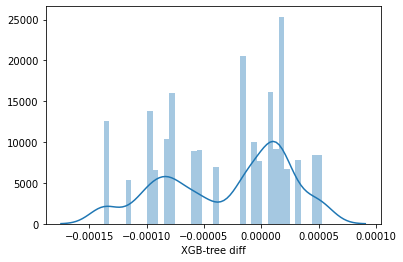

In [29]:
sn.distplot(predictions['XGB-tree diff'], bins=40)

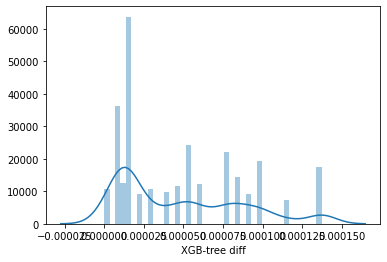

In [30]:
sn.distplot(np.abs(predictions['XGB-tree diff']), bins=40)

Jak widać w praktyce róznice pomiędzy tymi dwoma modelami na zbiorze testowym są naprawdę minimalne. Wybór pomiędzy nimi zależy od innych kryteriów jak np. możliwość wyjaśnienia predykcji gdzie model drzewiasty powinien sprawdzić się lepiej.
